In [1]:
# These imports and path modifications are only necessary for development
import importlib

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

# BacSC general pipeline - Tutorial

This tutorial covers how to use the BacSC pipeline to perform automated analysis of (bacterial) single-cell data. In this tutorial, we analyze B.subtilis grown in minimal media, that were sequenced with the ProBac method (McNulty et al., 2023).

The easiest way to apply the same pipeline to your data is to copy this notebook and perform every step on your dataset

## Preprocessing
### Read data

In [20]:
# Adjust the data path and filename based on your folder structure
data_path = "../data/probe_Bac_scRNAseq_Rosenthal/B subtilis minimal media"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 2784 × 29765
    var: 'gene_ids', 'feature_types', 'genome'

### Aggregate probes through max-pooling

This step is only necessary for ProBac data, as it has reads from multiple probes for each gene

In [21]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool

Aggregating feature 100/2959
Aggregating feature 200/2959
Aggregating feature 300/2959
Aggregating feature 400/2959
Aggregating feature 500/2959
Aggregating feature 600/2959
Aggregating feature 700/2959
Aggregating feature 800/2959
Aggregating feature 900/2959
Aggregating feature 1000/2959
Aggregating feature 1100/2959
Aggregating feature 1200/2959
Aggregating feature 1300/2959
Aggregating feature 1400/2959
Aggregating feature 1500/2959
Aggregating feature 1600/2959
Aggregating feature 1700/2959
Aggregating feature 1800/2959
Aggregating feature 1900/2959
Aggregating feature 2000/2959
Aggregating feature 2100/2959
Aggregating feature 2200/2959
Aggregating feature 2300/2959
Aggregating feature 2400/2959
Aggregating feature 2500/2959
Aggregating feature 2600/2959
Aggregating feature 2700/2959
Aggregating feature 2800/2959
Aggregating feature 2900/2959


AnnData object with n_obs × n_vars = 2784 × 2959
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

Let's look at the share of zero entries before and after probe-pooling. The zero inflation has decreased significantly

In [22]:
print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.986
Zero inflation of aggregated data: 0.911


### Filter cells

**This is the only step where manual setting of parameters is necessary!**

We perform some basic quality filtering on the data:
- Remove cells with less than 100 genes expressed
- Remove genes present in less than 2 cells
- Filter out outliers based on the median absolute deviation of counts (see plot below) - In this case, this actually removes no additional cells

In [23]:
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2, min_genes=100)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

False    2784
Name: outlier, dtype: int64
Total number of cells: 2784
Number of cells after filtering: 2784


AnnData object with n_obs × n_vars = 2784 × 2952
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

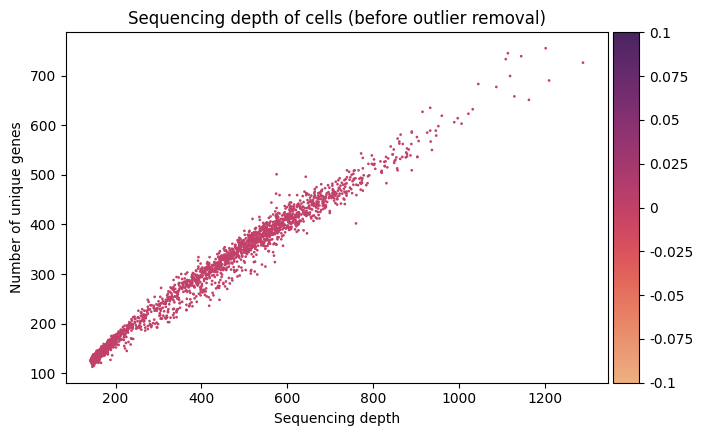

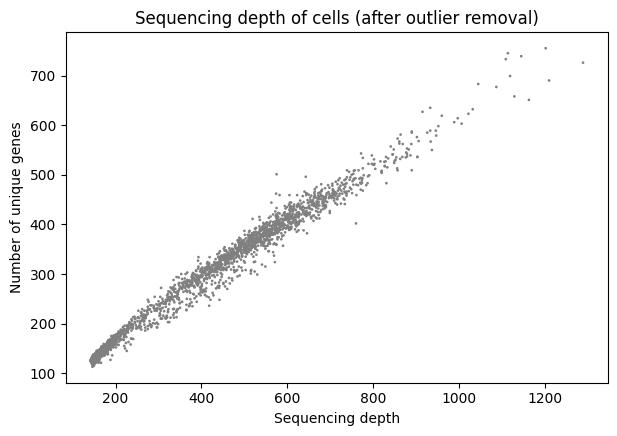

In [24]:
g = sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="flare", title="Sequencing depth of cells (before outlier removal)")
g.set(xlabel = "Sequencing depth")
g.set(ylabel="Number of unique genes")
plt.tight_layout()
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is not overdispersed. Therefore, we will use Poisson count splitting

In [25]:
# Save raw counts into a layer of the anndata
data_gene.layers["counts"] = data_gene.X.copy()

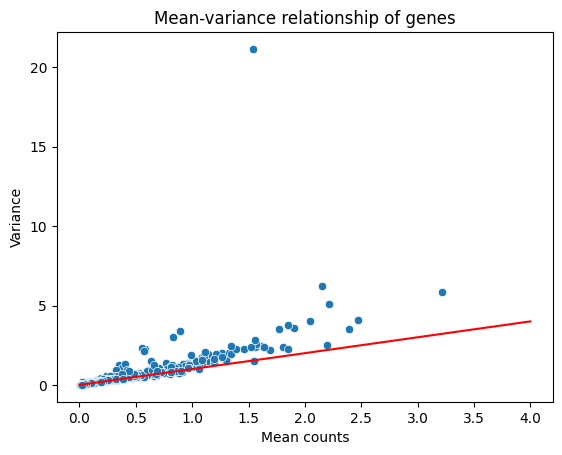

In [26]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

In [27]:
# See if a linear or quadratic relationship fits better 
mv_corr_lin = np.corrcoef(data_gene.var["mean_counts"], data_gene.var["var_counts"])[0,1]
mv_corr_sq = np.corrcoef(data_gene.var["mean_counts"]**2, data_gene.var["var_counts"])[0,1]

if mv_corr_sq > mv_corr_lin:
    is_overdispersed = True
else:
    is_overdispersed = False
    
if is_overdispersed:
    print("Data is overdispersed - use Negative Binomial count splitting")
else:
    print("Data is not overdispersed - use Poisson count splitting")


Data is not overdispersed - use Poisson count splitting


## Estimate negative binomial parameters for each gene

We use scTransform to estimate the dispersion parameter for each gene, which we will use for variance stabilization

In [28]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform", seed=1234)

In [29]:
data_gene.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,nb_overdisp_cutoff,nb_mean,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct
Sr1,Gene Expression,PA01,30,0.012931,0.012848,98.922414,36.0,3.610918,30,0.017074,False,0.051670,0.051670,-4.292421,-0.054207,-4.586321,0.095632,0.101964
aadK,Gene Expression,PA01,163,0.065733,0.063663,94.145115,183.0,5.214936,163,0.077217,False,0.369970,0.369970,-7.390090,1.824913,NaN,NaN,NaN
aag,Gene Expression,PA01,15,0.006106,0.006088,99.461207,17.0,2.890372,15,0.007506,False,0.026990,0.026990,-5.165194,-0.006868,-7.060510,0.780658,0.069086
aapA,Gene Expression,PA01,273,0.108118,0.102663,90.193966,301.0,5.710427,273,0.117262,False,0.826125,0.826125,-8.056778,2.278554,-6.187090,1.560799,0.020054
abbA,Gene Expression,PA01,308,0.133980,0.125733,88.936782,373.0,5.924256,308,0.173501,False,1.081945,1.081945,-8.138486,2.376904,-9.582205,2.934016,0.042674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znuB,Gene Expression,PA01,106,0.042026,0.041167,96.192529,117.0,4.770685,106,0.048162,False,0.203507,0.203507,-6.277588,1.218339,-4.852723,0.670688,0.044791
znuC,Gene Expression,PA01,33,0.013649,0.013557,98.814655,38.0,3.663562,33,0.017773,False,0.054614,0.054614,-4.219837,-0.056325,-8.111126,1.504564,0.069545
zosA,Gene Expression,PA01,36,0.015805,0.015681,98.706897,44.0,3.806662,36,0.022020,False,0.060985,0.060985,-4.147159,-0.033553,-1.751490,-0.975499,0.106674
zur,Gene Expression,PA01,66,0.024784,0.024482,97.629310,69.0,4.248495,66,0.026325,False,0.107861,0.107861,-4.814632,0.439308,NaN,NaN,NaN


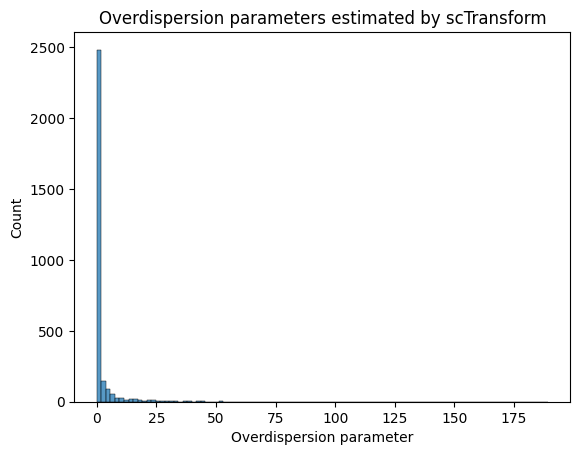

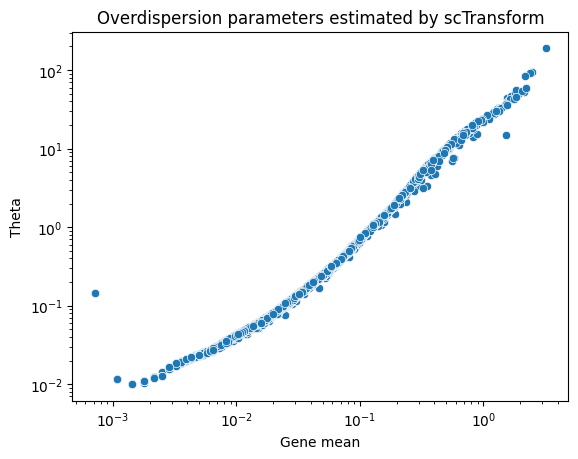

In [30]:
# Quick diagnostic plot - maybe we can spot some outlier genes here that prompt further investigation
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log", yscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [31]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

Normalize, scale and perform PCA on the data

In [32]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
if is_overdispersed:
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
else:
    data_gene.X = sps.csr_matrix(np.sqrt(data_gene.X.toarray()))
data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
sc.tl.pca(data_gene, svd_solver='arpack')

Histograms of cell sequencing depths before normalization, after VST and after scaling. The data should be more centered than before

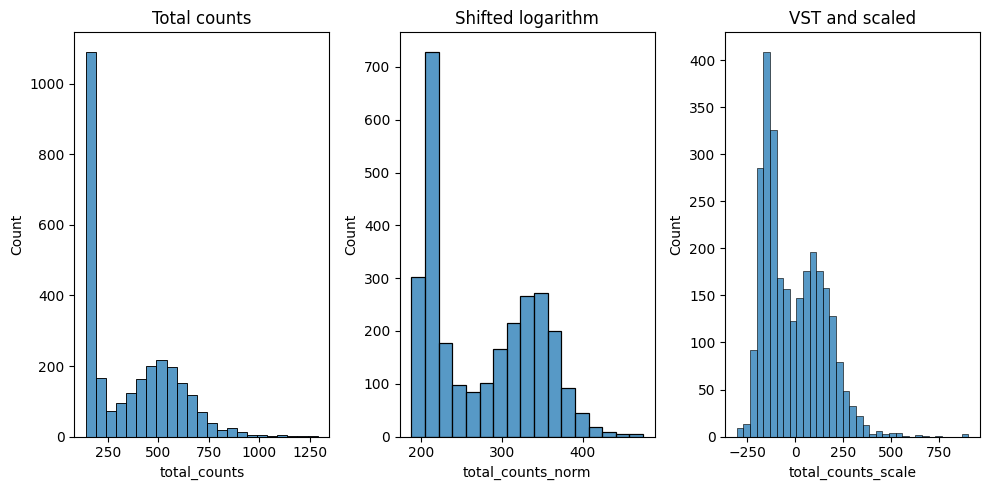

In [33]:

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

This step creates a train and test dataset, which we use to determine the latent dimensionality and clustering resolution further down the line

In [34]:
if is_overdispersed:
    data_dist = "NB"
else:
    data_dist = "Poi"
data_train, data_test = cs.countsplit_adata(data_gene, data_dist=data_dist, beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 2784 × 2929
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    layers: 'counts'


Process the data in the same way as the fulld dataset (Normalize, scale, PCA)

In [35]:
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

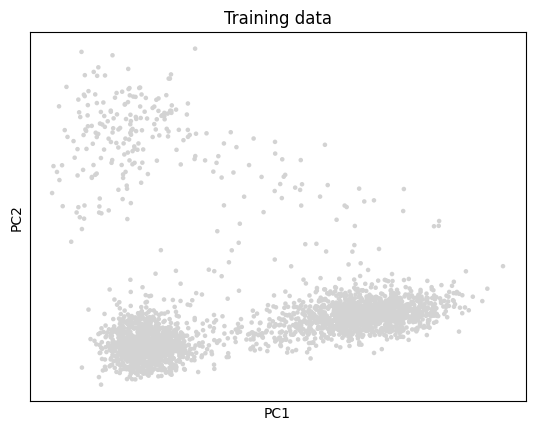

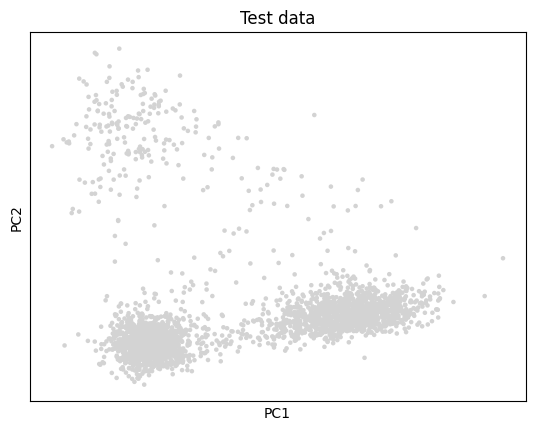

In [36]:
sc.pl.pca(data_train, title="Training data")
plt.show()

sc.pl.pca(data_test, title="Test data")
plt.show()

### Principal component selection

Select the optimal latent dimensionality k - the curve below should have a nice minimum

In [37]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")
data_gene.uns["BacSC_params"] = {"k_opt": k_opt}

Optimal number of PCs:4


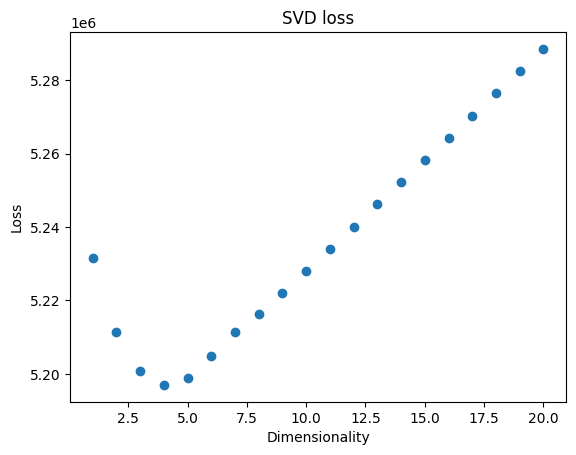

In [38]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

Plot the PCA of the full dataset

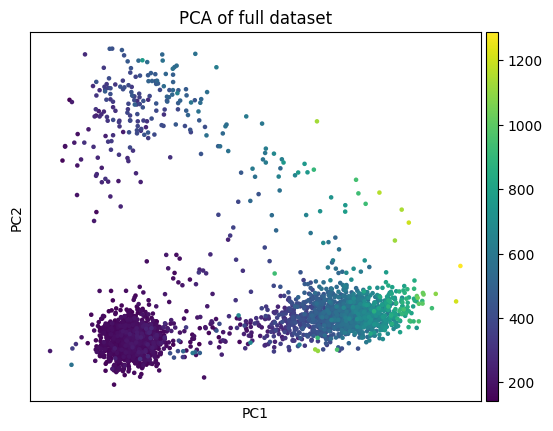

In [39]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

We now select parameters for the UMAP embedding. This is done with scDEED (Xia et al., 2023). Depending on the grid of values to test, this might take a while (in this example about 30 minutes).
The results are checkpointed after each parameter set, so you can always extend your parameter range

A representative set of parameters is given below, so that this step can be skipped

In [40]:
seed = 140
print(seed)

140


In [41]:
n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=seed, embedding_method="UMAP", similarity_percent=0.5, save_path="S3_filtered_scdeed_tutorial")

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

Plot the scDEED results. The plot might not exhibit a clear minimum, but we still take the parameter combination that has the least number of dubiously embedded cells

Optimal number of neighbors: 50
Optimal min_dist: 0.3


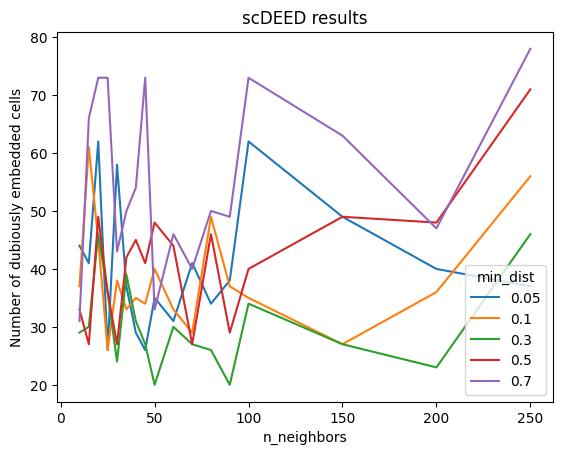

In [42]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [43]:
# Use these parameters if you don't want to run scDEED
# n_neighbors_opt = 20
# min_dist_opt = 0.5

In [44]:
# Save parameters to data object
data_gene.uns["BacSC_params"]["n_neighbors_opt"] = n_neighbors_opt
data_gene.uns["BacSC_params"]["min_dist_opt"] = min_dist_opt

Compute and plot the resulting UMAP. The coloring by embedding reliability is only possible, if scDEED was performed

NOTE: UMAPs are rotation/mirroring invariant, so they might appear slightly different every time

In [45]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=3456)


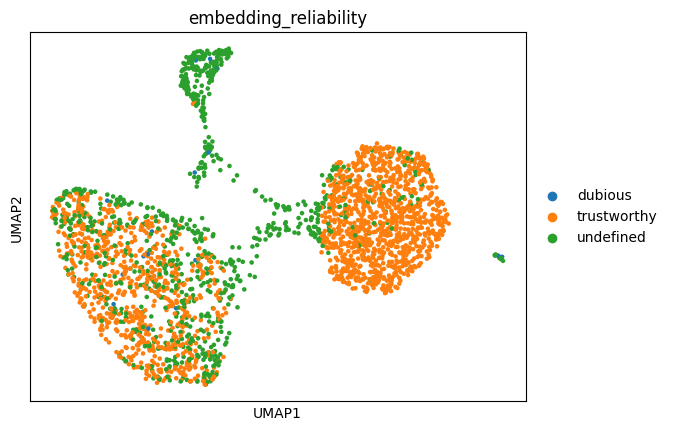

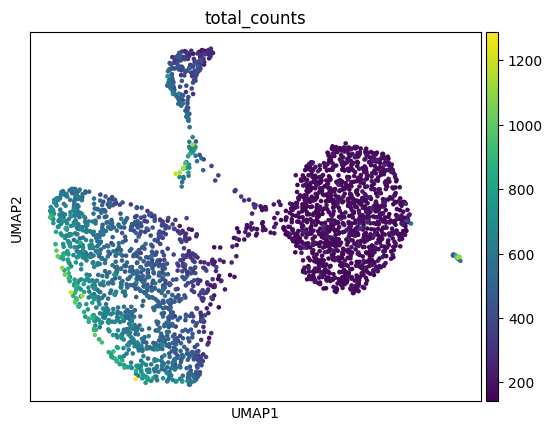

In [47]:
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

**Checkpoint** 

Save the data to disk and read it again

In [48]:
data_gene.write(data_path + "/filtered_data_maxpool_processed_tutorial.h5ad")

In [49]:
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed_tutorial.h5ad")
data_gene

AnnData object with n_obs × n_vars = 2784 × 2952
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'BacSC_params', 'embedding_reliability_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

## Clustering

We now apply Leiden clustering to the data. For this, we need to find a resolution parameter that points out the clusters in the data well

### Train/test-split for clustering

We apply the UMAP embedding with the previously calculated parameters to the train and test data.

In [50]:
k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]

sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

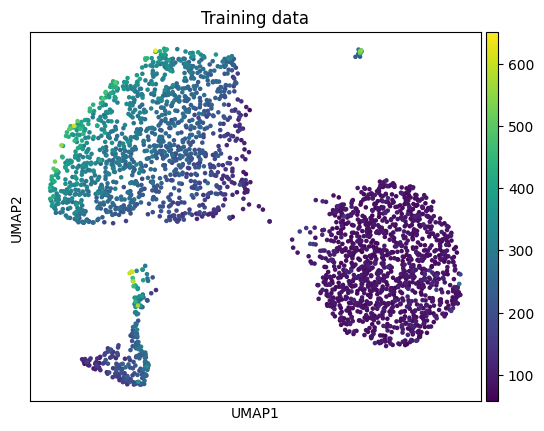

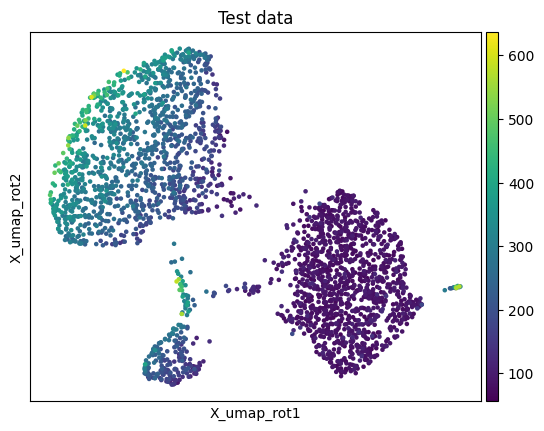

In [51]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

This step might also take a few minutes, based on the size of the data. You can also adjust the range of considered resolutions

In [106]:
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)
print(f"Resolutions to test: {resolutions}")

#234
co.cluster_train_test(data_train, data_test, resolutions, alg="leiden", random_state=234)

Resolutions to test: [0.01 0.03 0.05 0.07 0.09 0.11 0.13 0.15 0.17 0.19 0.21 0.23 0.25 0.27
 0.29 0.31 0.33 0.35 0.37 0.39 0.41 0.43 0.45 0.47 0.49]


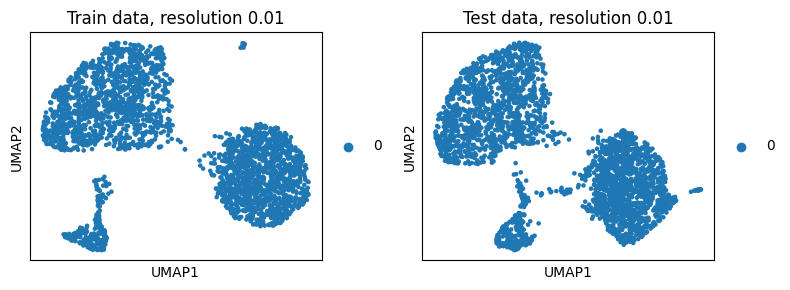

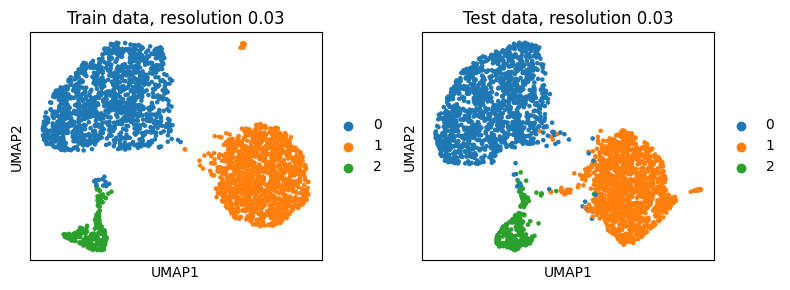

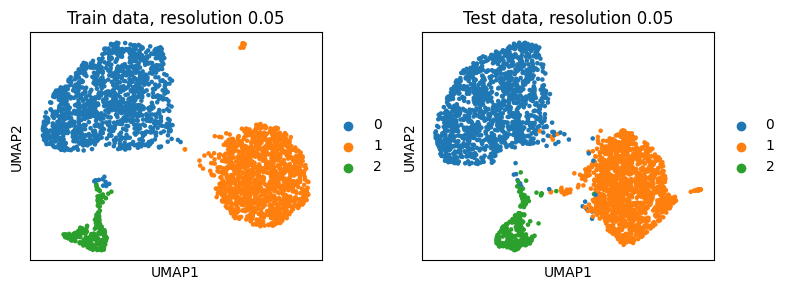

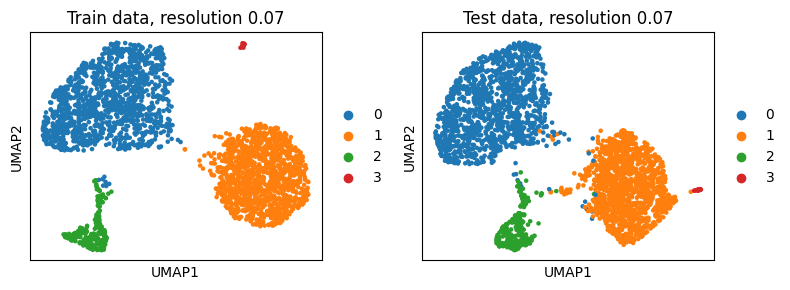

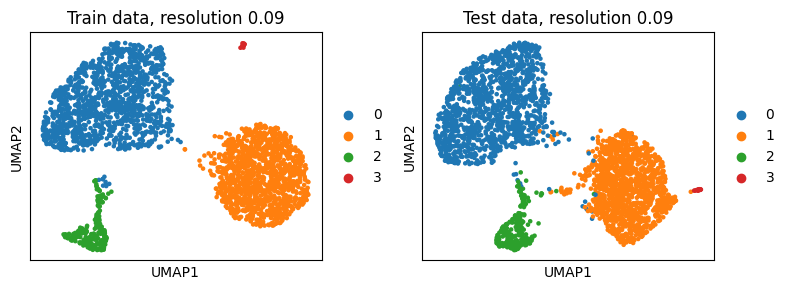

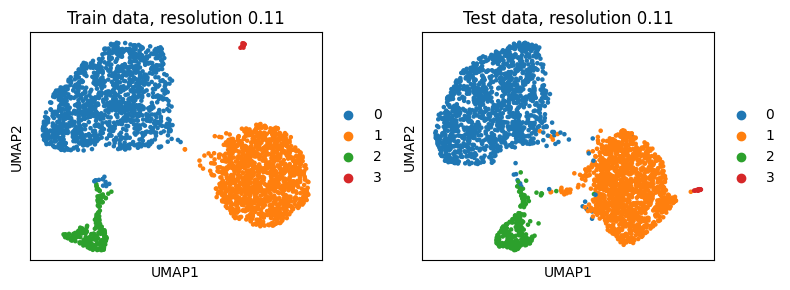

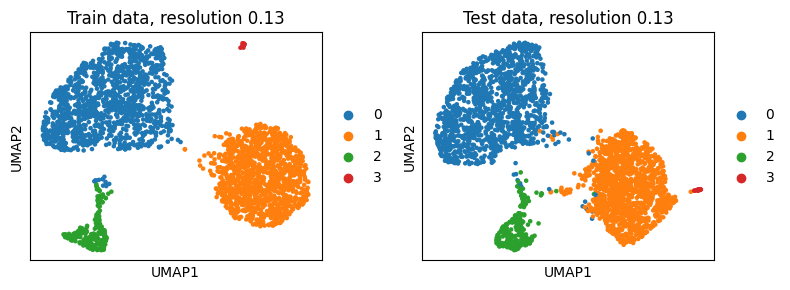

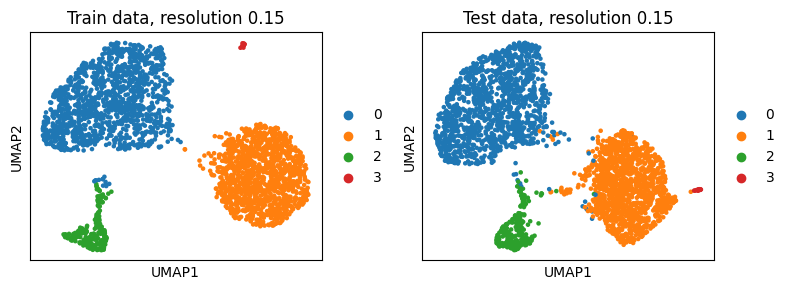

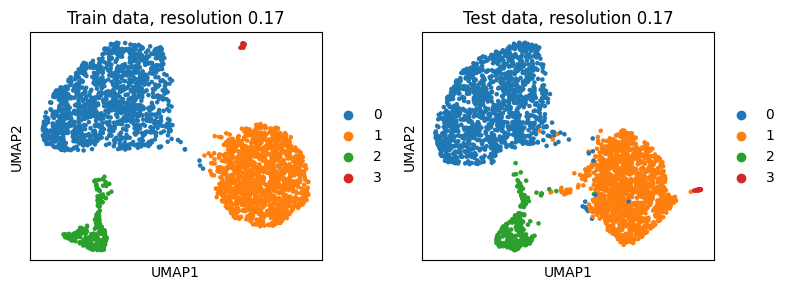

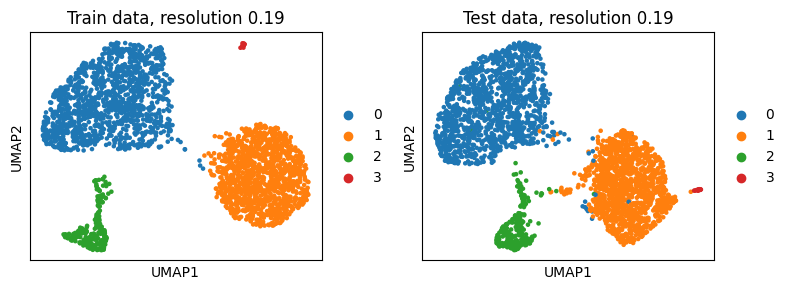

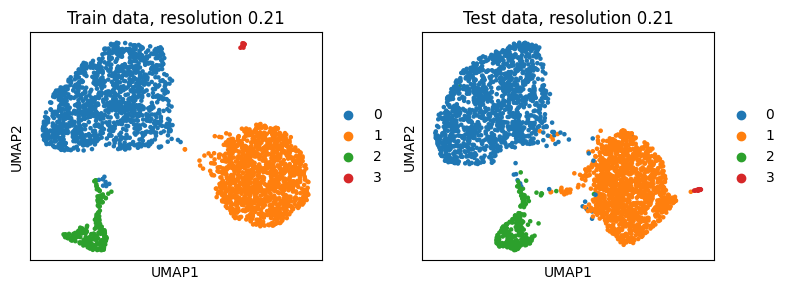

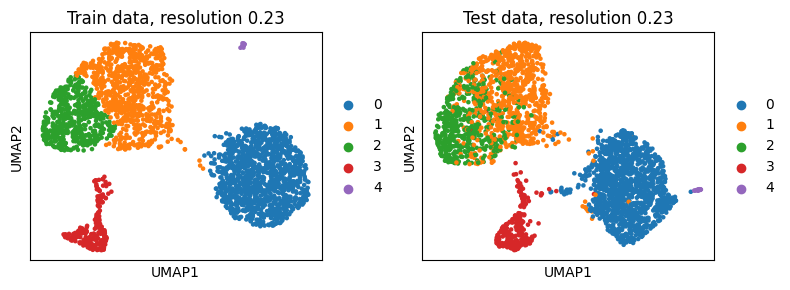

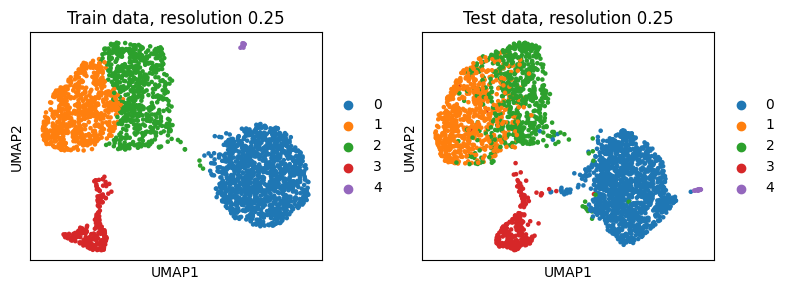

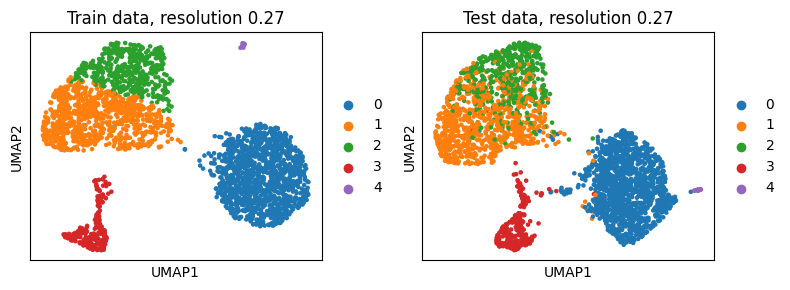

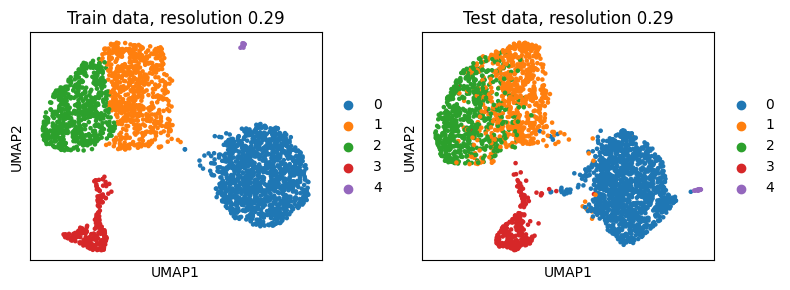

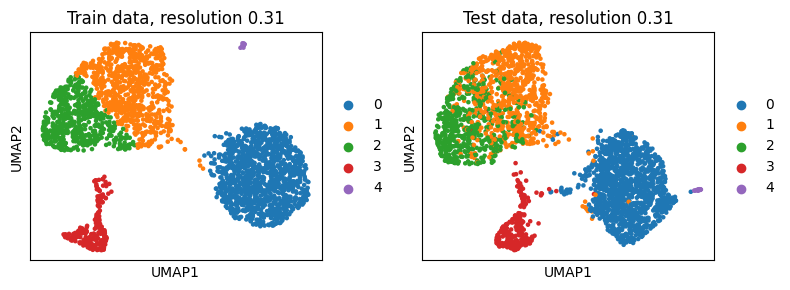

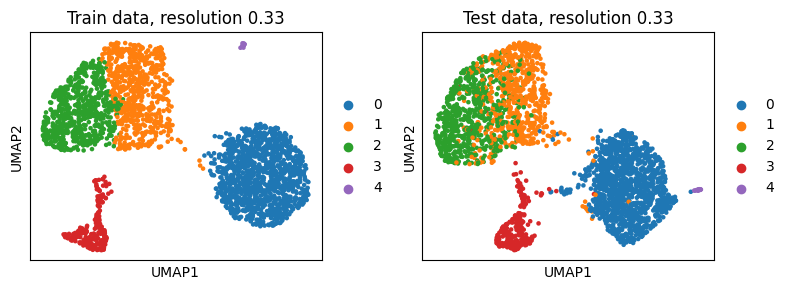

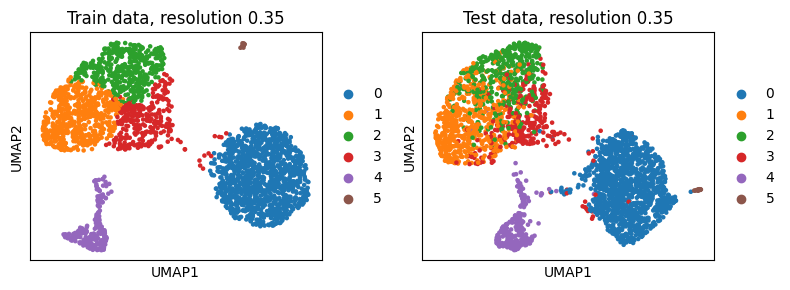

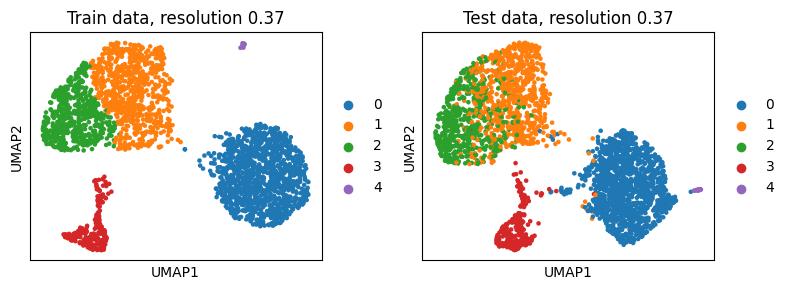

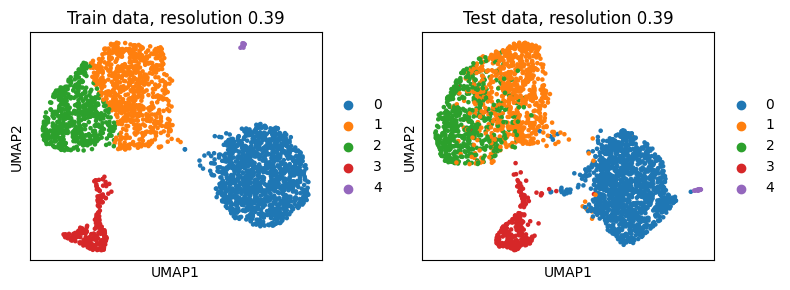

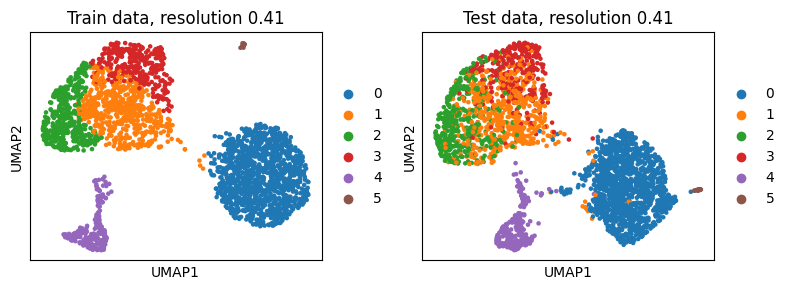

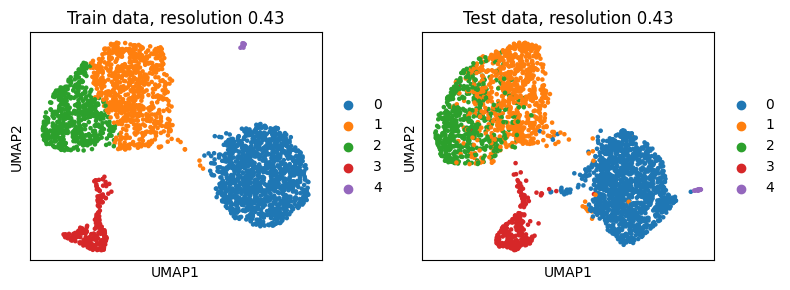

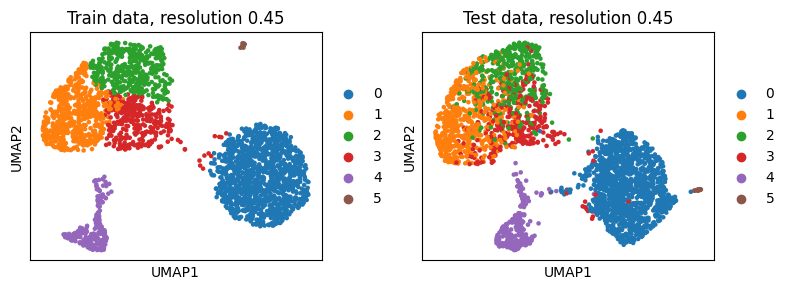

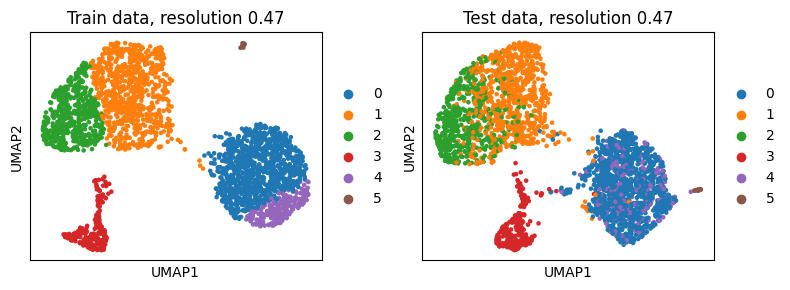

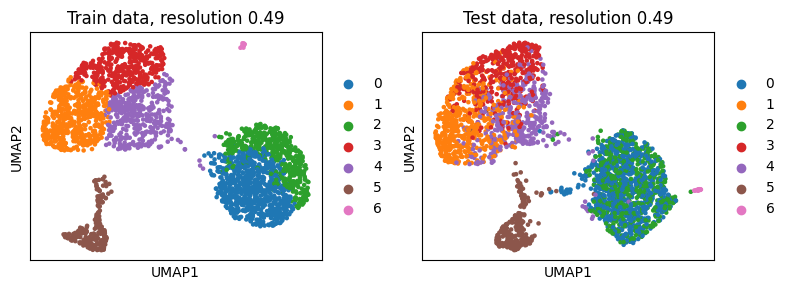

In [107]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(data_train, color=f"leiden_res{resolution}", ax=ax[0], title=f"Train data, resolution {resolution}", show=False)
    sc.pl.embedding(data_test, basis="X_umap_rot", color=f"leiden_res{resolution}", ax=ax[1], title=f"Test data, resolution {resolution}", show=False)
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

Compute modularities on train data for each clustering and select resolution with biggest increase in resolution on train data over a random clustering

In [108]:
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions)

print(f"Optimal resolution {res_opt}")


resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 3 - Train: 0.481 - Test: 0.477 - Random: 0.202
resolution: 0.05 - clusters: 3 - Train: 0.472 - Test: 0.468 - Random: 0.192
resolution: 0.07 - clusters: 4 - Train: 0.461 - Test: 0.457 - Random: 0.18
resolution: 0.09 - clusters: 4 - Train: 0.453 - Test: 0.449 - Random: 0.173
resolution: 0.11 - clusters: 4 - Train: 0.444 - Test: 0.441 - Random: 0.164
resolution: 0.13 - clusters: 4 - Train: 0.436 - Test: 0.432 - Random: 0.156
resolution: 0.15 - clusters: 4 - Train: 0.427 - Test: 0.424 - Random: 0.148
resolution: 0.17 - clusters: 4 - Train: 0.418 - Test: 0.414 - Random: 0.139
resolution: 0.19 - clusters: 4 - Train: 0.409 - Test: 0.405 - Random: 0.13
resolution: 0.21 - clusters: 4 - Train: 0.402 - Test: 0.398 - Random: 0.122
resolution: 0.23 - clusters: 5 - Train: 0.4 - Test: 0.361 - Random: 0.087
resolution: 0.25 - clusters: 5 - Train: 0.393 - Test: 0.358 - Random: 0.077
resolution: 0.27 - 

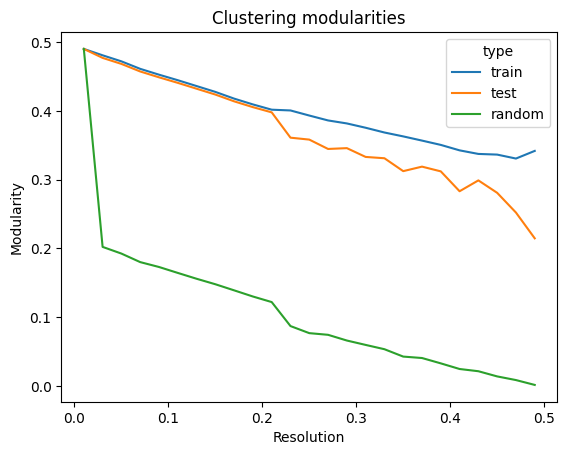

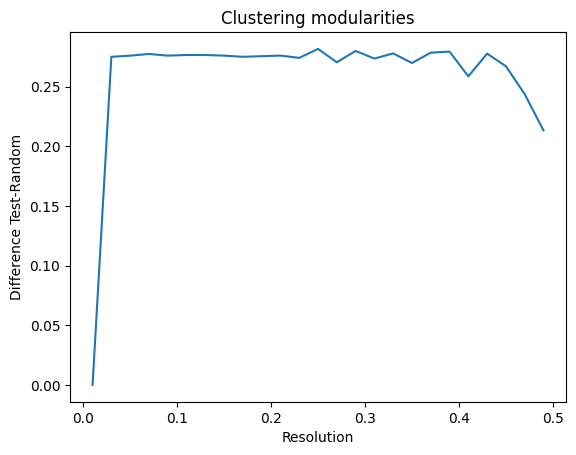

In [109]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Modularity")
plt.show()

sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

In [110]:
# Checkpoint value for resolution to reduce computation time
res_opt = 0.23
data_gene.uns["BacSC_params"]["res_opt"] = res_opt


### Apply clustering to full dataset

In [111]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt", random_state=1234)

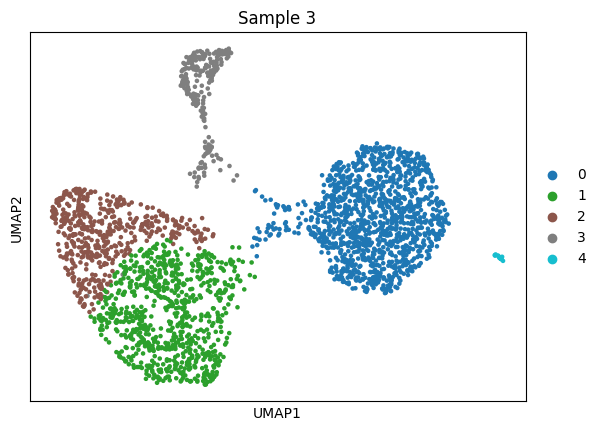

In [112]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

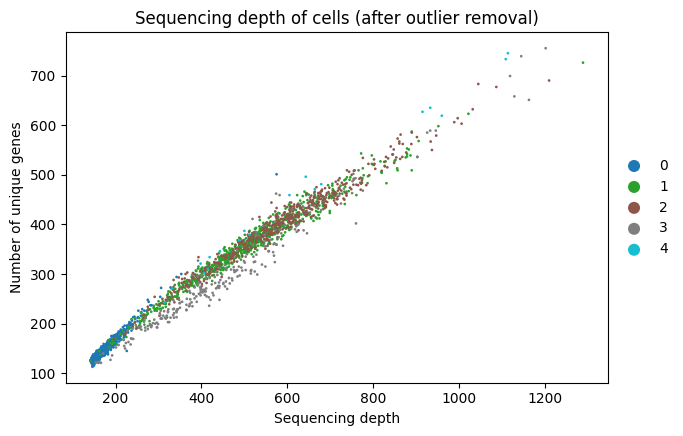

In [113]:
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

**Checkpoint**

Save the data to disk and read it again

In [70]:
data_gene.write(data_path + "/filtered_data_maxpool_processed_tutorial.h5ad")

## Attach feature table

In [77]:
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed_tutorial.h5ad")
data_gene

AnnData object with n_obs × n_vars = 2784 × 2952
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'BacSC_params', 'embedding_reliability_colors', 'leiden_opt', 'leiden_opt_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [78]:
# Adjust the path to the feature table
feature_table = pd.read_csv("../data/MOBA_scRNAseq/P_aeruginosa_PAO1_feature_table.tsv", sep="\t")
feature_table = feature_table[["Locus tag", "Protein accession", "Name", "Symbol"]]
feature_table["Locus tag"] = [str(x) for x in feature_table["Locus tag"]]
feature_table

,Locus tag,Protein accession,Name,Symbol
0,PA0001,NP_064721.1,chromosome replication initiator DnaA,dnaA
1,PA0002,NP_064722.1,DNA polymerase III subunit beta,dnaN
2,PA0003,NP_064723.1,DNA replication and repair protein RecF,recF
3,PA0004,NP_064724.1,DNA gyrase subunit B,gyrB
4,PA0005,NP_064725.1,lysophosphatidic acid acyltransferase,lptA
...,...,...,...,...
5692,PA5566,NP_254253.1,hypothetical protein,NaN
5693,PA5567,NP_254254.1,tRNA modification GTPase TrmE,NaN
5694,PA5568,NP_254255.1,inner membrane protein translocase subunit YidC,NaN
5695,PA5569,NP_254256.1,ribonuclease P,rnpA


In [79]:
df3=data_gene.var.reset_index().merge(feature_table, how='left', left_on='index', right_on='Symbol').drop_duplicates("index").set_index("index")
data_gene.var = df3
data_gene.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,...,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct,mean,std,Locus tag,Protein accession,Name,Symbol
index,,,,,,,,,,,,,,,,,,,,,
Sr1,Gene Expression,PA01,30,0.012931,0.012848,98.922414,36.0,3.610918,30,0.017074,...,-0.054207,-4.586321,0.095632,0.101964,0.012465,0.126453,NaN,NaN,NaN,NaN
aadK,Gene Expression,PA01,163,0.065733,0.063663,94.145115,183.0,5.214936,163,0.077217,...,1.824913,NaN,NaN,NaN,0.064862,0.275779,NaN,NaN,NaN,NaN
aag,Gene Expression,PA01,15,0.006106,0.006088,99.461207,17.0,2.890372,15,0.007506,...,-0.006868,-7.060510,0.780658,0.069086,0.005736,0.083054,NaN,NaN,NaN,NaN
aapA,Gene Expression,PA01,273,0.108118,0.102663,90.193966,301.0,5.710427,273,0.117262,...,2.278554,-6.187090,1.560799,0.020054,0.097890,0.314738,NaN,NaN,NaN,NaN
abbA,Gene Expression,PA01,308,0.133980,0.125733,88.936782,373.0,5.924256,308,0.173501,...,2.376904,-9.582205,2.934016,0.042674,0.104500,0.313235,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znuB,Gene Expression,PA01,106,0.042026,0.041167,96.192529,117.0,4.770685,106,0.048162,...,1.218339,-4.852723,0.670688,0.044791,0.040955,0.215316,PA5501,NP_254188.1,zinc ABC transporter permease,znuB
znuC,Gene Expression,PA01,33,0.013649,0.013557,98.814655,38.0,3.663562,33,0.017773,...,-0.056325,-8.111126,1.504564,0.069545,0.011902,0.117511,PA5500,NP_254187.1,zinc transporter ZnuC,znuC
zosA,Gene Expression,PA01,36,0.015805,0.015681,98.706897,44.0,3.806662,36,0.022020,...,-0.033553,-1.751490,-0.975499,0.106674,0.016122,0.148504,NaN,NaN,NaN,NaN


Save final dataset

In [80]:
data_gene.write(data_path + "/filtered_data_maxpool_processed_tutorial.h5ad")

This concludes the main BacSC pipeline. To perform differential expression analysis, continue with the clustering analysis tutorial.